# Carnatic Beat Detection: what is that beat?


### Overview

This project develops an ML/AI classifier that identifies the Carnatic beat cycle (taalam) of a mridangam solo


### Goal

Given a clip of a drum solo, identify the taalam (beat cycle) in which it is performed.

While there are 5 main taalam types that are commonly performed (and in principle thousands of possible taalams), I have restricted the scope of this project to 3 well-known and often-used taalams: aadi talam (8-beat cycle), mishra-chapu talam (7 beat cycle) and khanda-chapu talam (5-beat cycle).

### Data

In [27]:
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import seaborn as sns
import os
import random
import math

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, TargetEncoder, LabelEncoder
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score

import time
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential


In [28]:
# Load the data
beatsDf1 = pd.read_csv("data/Beats-3Class.csv")

# if running in Google CoLab:
#beatsDf1 = pd.read_csv("/content/Beats-3Class.csv")

beatsDf1.sample(7)

,FileName,Beat,1,2,3,4,5,6,7,8,...,491,492,493,494,495,496,497,498,499,500
58,Aadi-2,A,0.003766,0.014774,0.019409,0.024623,0.030127,0.032735,0.035342,0.037949,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90,KhandaChapu2020,K,0.000868,0.002604,0.006366,0.008391,0.011574,0.014757,0.018229,0.022859,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79,KhandaChapu2009,K,0.000000,0.002328,0.004948,0.007276,0.010477,0.013679,0.016589,0.018917,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65,MisraChapu-3,M,0.004348,0.007826,0.009855,0.014783,0.017971,0.022319,0.024058,0.026957,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95,KhandaChapu2025,K,0.002612,0.006674,0.014800,0.018282,0.020023,0.022345,0.024086,0.025827,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
111,MisraChapu106,M,0.000869,0.004635,0.008691,0.011008,0.012746,0.015643,0.019988,0.022885,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Aadi-1001,A,0.000000,0.001448,0.003476,0.005214,0.006952,0.011008,0.014195,0.017961,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
beatsDf1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Columns: 502 entries, FileName to 500
dtypes: float64(500), object(2)
memory usage: 455.1+ KB


#### Cleanup 1:
We will set the number of numeric (time-lapse) features to be 250. Drop features with names > 250.

In [30]:
# We will drop features with names 251 -- 500
featuresToDrop = []
for nn in range(251, 501):
    featuresToDrop.append(str(nn))

In [31]:
# Drop the columns above
beatsDf1 = beatsDf1.drop(featuresToDrop, axis = 1)

In [32]:
beatsDf1.sample(7)

,FileName,Beat,1,2,3,4,5,6,7,8,...,241,242,243,244,245,246,247,248,249,250
89,KhandaChapu2019,K,0.002031,0.005804,0.010157,0.013929,0.017702,0.020023,0.022345,0.025827,...,0.760012,0.762333,0.764074,0.768137,0.769878,0.772200,0.776262,0.780325,0.782647,0.784388
88,KhandaChapu2018,K,0.000291,0.003783,0.008440,0.011932,0.015716,0.019790,0.022992,0.027357,...,0.728172,0.730792,0.734284,0.736903,0.739523,0.742142,0.743597,0.745343,0.747381,0.750582
55,UKS-KhandaChapu-101,K,0.001181,0.004135,0.009746,0.013881,0.018311,0.024808,0.030715,0.056999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52,Palghat Raghu Misra Chapu - 101,M,0.002902,0.004933,0.009867,0.016251,0.021764,0.024956,0.028439,0.033952,...,0.964016,0.973302,0.976785,0.982879,0.988683,0.991875,0.994777,0.998259,NaN,NaN
57,Aadi-1,A,0.000293,0.001755,0.004681,0.009070,0.011410,0.013751,0.017262,0.034816,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100,MishraChapu2000,M,0.000868,0.002604,0.004340,0.006655,0.008391,0.012442,0.014178,0.016204,...,0.748264,0.751447,0.755787,0.760706,0.765046,0.768519,0.771123,0.773438,0.777199,0.780382
2,Aadi-1002,A,0.002040,0.006410,0.009324,0.011364,0.013695,0.017191,0.019522,0.025058,...,0.795746,0.798660,0.800699,0.803322,0.806527,0.809441,0.811480,0.813228,0.815268,0.827214


In [33]:
beatsDf1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Columns: 252 entries, FileName to 250
dtypes: float64(250), object(2)
memory usage: 228.5+ KB


#### Cleanup 2:
Drop rows with NaNs. These are really short clips and probably will not contain sufficient data for analysis. There is no meaningful way to fill in missing values.

In [34]:
beatsDf = beatsDf1.dropna()

In [35]:
beatsDf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101 entries, 0 to 115
Columns: 252 entries, FileName to 250
dtypes: float64(250), object(2)
memory usage: 199.6+ KB


In [36]:
beatsDf.sample(5)

,FileName,Beat,1,2,3,4,5,6,7,8,...,241,242,243,244,245,246,247,248,249,250
24,Aadi-1024,A,0.000580,0.004060,0.006961,0.010441,0.015081,0.018852,0.022622,0.027552,...,0.877900,0.881381,0.885151,0.890371,0.896172,0.902262,0.907193,0.909803,0.912413,0.916473
39,MisraChapu-1005,M,0.001162,0.004067,0.006682,0.026438,0.029343,0.031087,0.033411,0.036897,...,0.773969,0.777164,0.781813,0.783556,0.785299,0.791110,0.795177,0.799245,0.802731,0.807089
72,MisraChapu-1020,M,0.001453,0.005520,0.009587,0.015979,0.019175,0.021499,0.023533,0.025276,...,0.750726,0.753632,0.757408,0.762057,0.764962,0.769030,0.770773,0.773097,0.776293,0.781522
27,Aadi-1027,A,0.000581,0.003486,0.005230,0.006682,0.009006,0.013074,0.016560,0.020046,...,0.833818,0.839338,0.842243,0.843986,0.845729,0.848925,0.851540,0.855607,0.859965,0.865776
31,Aadi-1031,A,0.001448,0.004922,0.007817,0.009844,0.014186,0.016213,0.019687,0.023162,...,0.713665,0.717140,0.720614,0.722930,0.725246,0.727562,0.732195,0.734511,0.736827,0.740591


In [37]:
# Drop the "FileName" column
beatsDf = beatsDf.drop("FileName", axis = 1)

In [38]:
beatsDf.value_counts('Beat')

,count
Beat,
A,36
M,34
K,31


In [39]:
# For the current state of the data, we have only one 'K' beat.
#Drop it so that we have a 2-fold (binary) classification situation.
#beatsDf = beatsDf.drop(beatsDf[beatsDf.Beat == 'K'].index)

### Split data into training and test sets

In [40]:
# Data: indepndent and dependent variables
X = beatsDf.drop(['Beat'], axis = 1)

# target: the Beat type
labelEnc = LabelEncoder()
y = labelEnc.fit_transform(beatsDf['Beat'])

In [41]:
print(y[:5])

[0 0 0 0 0]


In [42]:
y_ohe = to_categorical(y)

### ANSWER CHECK
print(y_ohe[:5])

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [43]:
rand_state = 44
# Data, split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = rand_state)

In [44]:
# Scale X
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [45]:
y_ohe_train = to_categorical(y_train)
y_ohe_test = to_categorical(y_test)

### Optimizing the Neural Net model: number of hidden layers and number of nodes

In [46]:
def create_Seq_model(nLayers, nNodes, nClasses):
  modelName = 'Model_' + str(nLayers) + '-layers_' + str(nNodes) + '-nodes_' +  str(nClasses) + '-classes'
  model = Sequential(name = modelName)
  # Hidden layers
  for ii in range(nLayers):
    model.add(Dense(nNodes, activation="relu"))
  # The final output layer
  model.add(Dense(nClasses, activation="softmax"))
  return model


In [47]:
model_results = []

numClasses = 3
maxNumLayers = 8
numEpochs = 100
for numLay in range(2, maxNumLayers + 1):
  for numNodes in range(30, 91, 30):
    mm = create_Seq_model(nLayers = numLay, nNodes = numNodes, nClasses = numClasses)
    mm.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'])
    history_mm = mm.fit(X_train_scaled, y_ohe_train, epochs = numEpochs, verbose = 0, batch_size = 3, validation_data = (X_test_scaled, y_ohe_test))

    accuracies_mm = history_mm.history['accuracy']
    validation_accuracies_mm = history_mm.history['val_accuracy']
    model_results.append({
            'Layers': numLay,
            'Nodes': numNodes,
            'fit_accuracy': accuracies_mm[-1],
            'validation_accuracy': validation_accuracies_mm[-1]
            })


In [48]:
# Dataframe out of the results
modelResultsDf = pd.DataFrame(model_results)
modelResultsDf

,Layers,Nodes,fit_accuracy,validation_accuracy
0,2,30,0.9375,0.428571
1,2,60,0.9500,0.333333
2,2,90,0.9000,0.428571
3,3,30,0.8875,0.523810
4,3,60,0.9375,0.380952
5,3,90,0.9250,0.190476
6,4,30,0.9500,0.380952
7,4,60,0.9375,0.333333
8,4,90,0.9375,0.333333
9,5,30,0.9625,0.428571


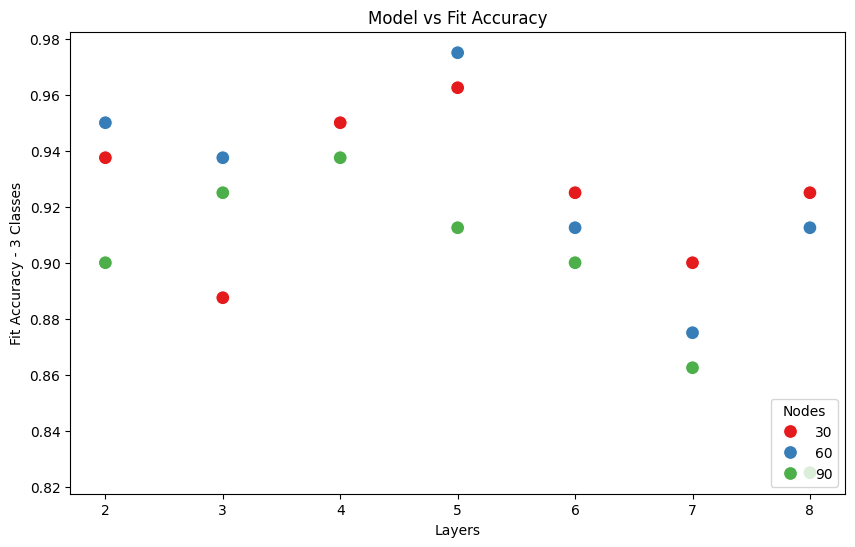

In [49]:
figg, axx = plt.subplots(figsize=(10, 6))

plt1 = sns.scatterplot(data=modelResultsDf, x='Layers', y='fit_accuracy', hue='Nodes', palette = 'Set1', s = 100)
sns.move_legend(plt1, loc='lower right')
plt1.set_title('Model vs Fit Accuracy')
plt1.set(xlabel='Layers', ylabel='Fit Accuracy - 3 Classes')
plt.show()
#plt1.get_figure().savefig("/content/Images/model_fit_accuracy_scatter.png")

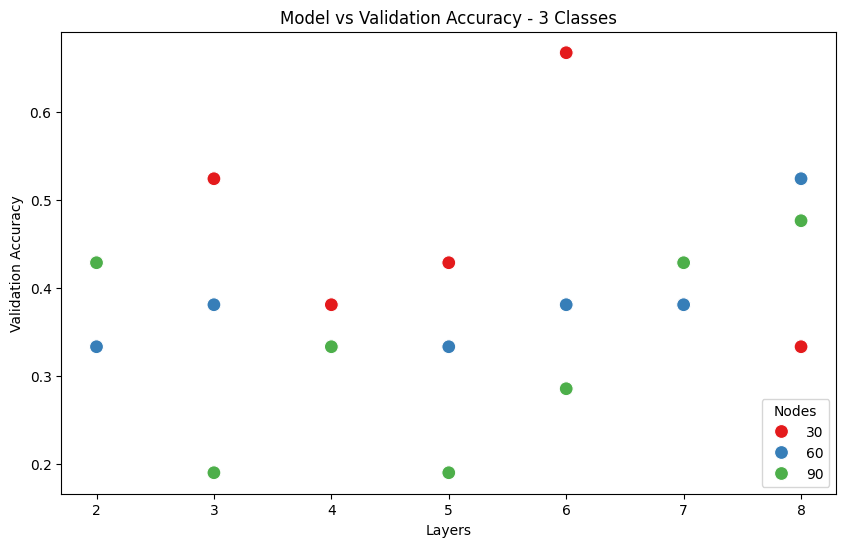

In [50]:
figg, axx = plt.subplots(figsize=(10, 6))
plt2 = sns.scatterplot(data=modelResultsDf, x='Layers', y='validation_accuracy', hue='Nodes', palette = 'Set1', s = 100)
sns.move_legend(plt2, loc='lower right')
plt2.set_title('Model vs Validation Accuracy - 3 Classes')
plt2.set(xlabel='Layers', ylabel='Validation Accuracy')
plt.show()
#plt2.get_figure().savefig("/content/Images/model_valid_accuracy_scatter.png")

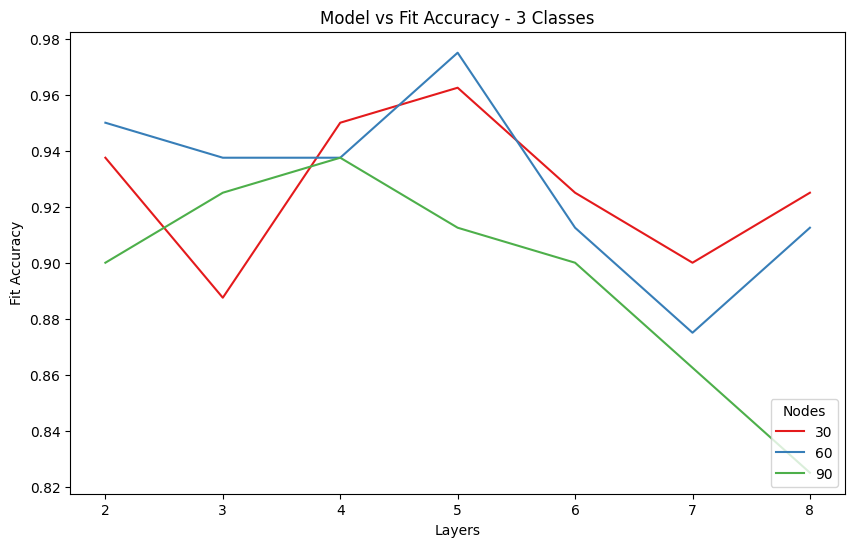

In [51]:
figg, axx = plt.subplots(figsize=(10, 6))
plt3 = sns.lineplot(data=modelResultsDf, x='Layers', y='fit_accuracy', hue='Nodes', palette = 'Set1')
sns.move_legend(plt3, loc='lower right')
plt3.set_title('Model vs Fit Accuracy - 3 Classes')
plt3.set(xlabel='Layers', ylabel='Fit Accuracy')
plt.show()
#plt3.get_figure().savefig("/content/Images/model_fit_accuracy_line.png")

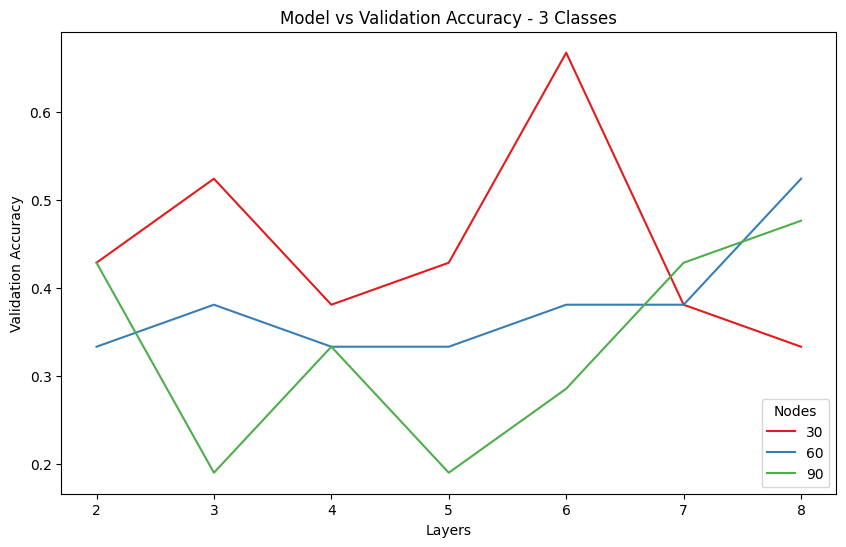

In [52]:
figg, axx = plt.subplots(figsize=(10, 6))
plt4 = sns.lineplot(data=modelResultsDf, x='Layers', y='validation_accuracy', hue='Nodes', palette = 'Set1')
sns.move_legend(plt4, loc='lower right')
plt4.set_title('Model vs Validation Accuracy - 3 Classes')
plt4.set(xlabel='Layers', ylabel='Validation Accuracy')
plt.show()
#plt4.get_figure().savefig("/content/Images/model_valid_accuracy_line.png")

### Evaluation

#### Model Accuracy
Some models fared better than random chance (0.33) but none were very impressive. The best validation scores are in the range of 0.5 to 0.66 (almost twice as good as random chance).  The simplest model with this score is (number of layers = 6, number of nodes = 30). More data is needed to make definitive conclusions about model accuracy.

#### Caveat
The above analysis was done with a very small dataset! The results might change as more data is generated and brought into the analysis.